# Observing-Suite

A suite of tools for planning and carrying out astronomical observations, building on astropy and inspired by astroplan.

This package is built around three core classes: `Target()`, where one specifies astronomical targets and various configurations of desired target, `ObservingPlan()`, which ingests a target list, sets up the observatory and nights of observation, creates *beautiful* html observing plans (with airmass plots, finder charts, etc) and exports observatory-ready target lists for all unique configurations, and `ObservingLog()`, which spawns an easy to use, but highly flexible, html entry tool that saves an observing log during the night.

Numerous convenience functions exist at each stage: my goal is to make it as easy as possible for me (and others) to set up complex observing runs yet keep track of everything. Some elements of this package are made better with instrument specific and observatory specific information. For now, Keck Observatory and Palomar Observatory are the two "most supported". I'll happily add more if people are interested and can provide, e.g., the template for that observatory's targetlist.

## Dependencies
Use of the observing-suite relies on the following

- numpy 
- matplotlib
- astropy
- pandas
- photutils
- astroquery

## Usage
Below, I demonstrate some of the basic usage of the tool.

### The Target() Class 

Our observing plan (later on) is going to ingest a list of `Target`s. Let's go ahead and define one, and see what convenience functions exist. As a note, if your observations are in the vicinity of a known (i.e., resolvable by `Simbad`) source, you can simply enter the name, leaving the `parse_name` argument to `True`:

In [1]:
from observing_suite import Target, ObservingPlan

In [2]:
m82 = Target('M82')

With our target defined, we also have a set of coordinates that are accessible (this worked because the resolved name provided the coordinates). 

In [3]:
m82.coordinates.to_string()

'148.968 69.6797'

The coordinates are standard `astropy.coordinates.SkyCoord` objects. Naturally, you can provide `SkyCoord` objects directly into the `Target` class:

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u
target_coord = SkyCoord('148.152 70.1215',unit='deg')

custom_target = Target(name='my galaxy',coordinates=target_coord,parse_name=False)

And finally, `Target()` provides the ability to supply coordinates without invoking SkyCoord directly. You can pass a string of coordinates (ra and dec), along with the keyword argument `coord_units`, which get fed to `SkyCoord`. 

In [5]:
final_target = Target(name='final_galaxy',coordinates='147.225 68.4242',coord_units=(u.deg,u.deg),parse_name=False)

In this case, I've demonstrated you can pass `coord_units` as a tuple of `astropy.Quantity` objects, but in this case, the string `'deg'` would've been fine too. 

Also notice that I've given these `Target`s names --- this will allow us to display and organize our targets moving forward.

### Adding Configurations

Every `Target` must have at least 1 valid `configuration`. A configuration refers to a specific way in which this object will be observed. One can add as many configurations as desired, which can be useful if, for example, you wish to perform spectroscopy on a target with varying PA angles or slit widths or gratings, or image a source in different filters. 

Let's add a configuration now. The most basic form of configuration doesn't specify *any* additional parameters:

In [6]:
m82.add_configuration(config_name='primary')

Notice that we also name our configurations, which will matter later for organization. At any time, we can visualize the configurations we've defined by the attribute

In [7]:
m82.configurations

,obstype,coordinates
configurations,,
primary,---,148.968 69.6797


or by running the explicit method

In [8]:
m82.list_configurations()

,obstype,coordinates
configurations,,
primary,---,148.968 69.6797


The configurations are visualized using `pandas.DataFrame`s, and you can take these frames and work with them as you wish. However, note that the DataFrame is only a *view* of your configurations, and modifying the returned frame doesn't modify your underlying configurations. 

We can notice here that this configuration has an `obstype` (unfilled), and `coordinates`, which were automagically set --- because we didn't specify any here, *and* the target itself had coordinates defined, they were pulled from there. It would've been `None` if we had initialized our `Target` without any coordinates (e.g., by supplying a non-parsed name and not providing coordinates). 

The configurations are supposed to be as flexible as possible, but certain *special* keywords also unlock special convenience functions. Let's re-do our primary configuration with some more flair:

In [9]:
m82.add_configuration(config_name='primary',
                      obstype='spectroscopy',
                      slit_length=128*u.arcsec,
                      slit_width=1.5*u.arcsec,
                      PA=60*u.deg)

Config Name primary already a configuration. Overwrite? [Enter yes, N for no]:  


Notice that we got a nice warning about overwriting our previous configuration with the same name! 

In [10]:
m82.configurations

,obstype,coordinates,slit_length,slit_width,PA
configurations,,,,,
primary,spectroscopy,148.968 69.6797,128.0 arcsec,1.5 arcsec,60.0 deg


We now have a more interesting configuration set for our "primary" configuration. I want to stress that the `add_configuration()` method will allow you to add any number of extra keywords and values, which will then be stored and accesible. So whatever quick-look info is useful to your observations, you should add. 

Let's add a secondary configuration:

In [11]:
m82.add_configuration(config_name='secondary',
                      obstype='spectroscopy',
                      slit_length=128*u.arcsec,
                      slit_width=4*u.arcsec,
                      PA=120*u.deg)

In [12]:
m82.configurations

,obstype,coordinates,slit_length,slit_width,PA
configurations,,,,,
primary,spectroscopy,148.968 69.6797,128.0 arcsec,1.5 arcsec,60.0 deg
secondary,spectroscopy,148.968 69.6797,128.0 arcsec,4.0 arcsec,120.0 deg


We now have a new configuration, specifying new slit width and PA. Nothing stops us from adding unique columns that only apply to some configurations:

In [13]:
m82.add_configuration(config_name='tertiary',
                      obstype='fiber spectroscopy',
                      fiber_radius=30*u.arcsec)
m82.configurations

,obstype,coordinates,slit_length,slit_width,PA,fiber_radius
configurations,,,,,,
primary,spectroscopy,148.968 69.6797,128.0 arcsec,1.5 arcsec,60.0 deg,---
secondary,spectroscopy,148.968 69.6797,128.0 arcsec,4.0 arcsec,120.0 deg,---
tertiary,fiber spectroscopy,148.968 69.6797,---,---,---,30.0 arcsec


This time, I've assumed we have a fiber with a radius, rather than a slit with a length and width. 

People familiar with faint object spectroscopy will be familiar with the concept of an offset star. You align on this (visible) source, and execute a blind offset to the target (hoping you got it right). 

We provide the functionality to add an offset star for any configuration, and the code will also calculate our offsets:

In [14]:
m82.add_offset_star(coordinate='148.928 69.6897',
                    coord_units='deg',
                    configurations='all')
m82.configurations

,obstype,coordinates,slit_length,slit_width,PA,offset star,offsets,fiber_radius
configurations,,,,,,,,
primary,spectroscopy,148.968 69.6797,128.0 arcsec,1.5 arcsec,60.0 deg,148.928 69.6897,"50.580 arcsec'' E, -35.973 arcsec'' N",---
secondary,spectroscopy,148.968 69.6797,128.0 arcsec,4.0 arcsec,120.0 deg,148.928 69.6897,"50.580 arcsec'' E, -35.973 arcsec'' N",---
tertiary,fiber spectroscopy,148.968 69.6797,---,---,---,148.928 69.6897,"50.580 arcsec'' E, -35.973 arcsec'' N",30.0 arcsec


I've supplied the coordinates for our offset star, which in this case can be applied to all configurations, because all our configurations have the same coordinates. But if you have different specific coordinates for each configuration, it would calculate the offsets from that star to each. You can also specify to add offsets only to one, or some, configurations (via a string name, or a list of string names of configurations). 

### Removing and Editing Configurations 

There are some convenience methods to allow you to `remove_configuration(config_name)` and `edit_configuration(config_name,property,value)` which are pretty self-explanatory. Editing is not super useful — you might as well change and readd (overwrite) your entry for that configuration. 

### Retrieving Finder Charts 

We can retrieve a DSS image (finder chart) for any configuration which has coordinates defined. 

In [16]:
%matplotlib inline

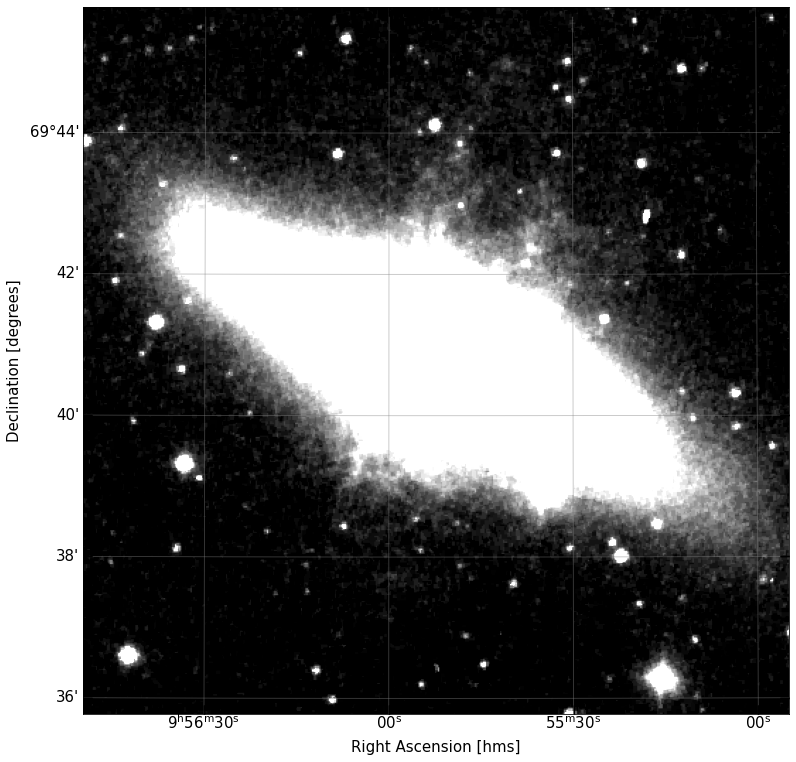

In [18]:
m82.retrieve_finder_chart(config_name='primary',
                         size=10*u.arcmin,
                         show_aperture=False);

In relieving news, M82 appears! Notice I set a specific keyword to *not* show aperture. What was that about?

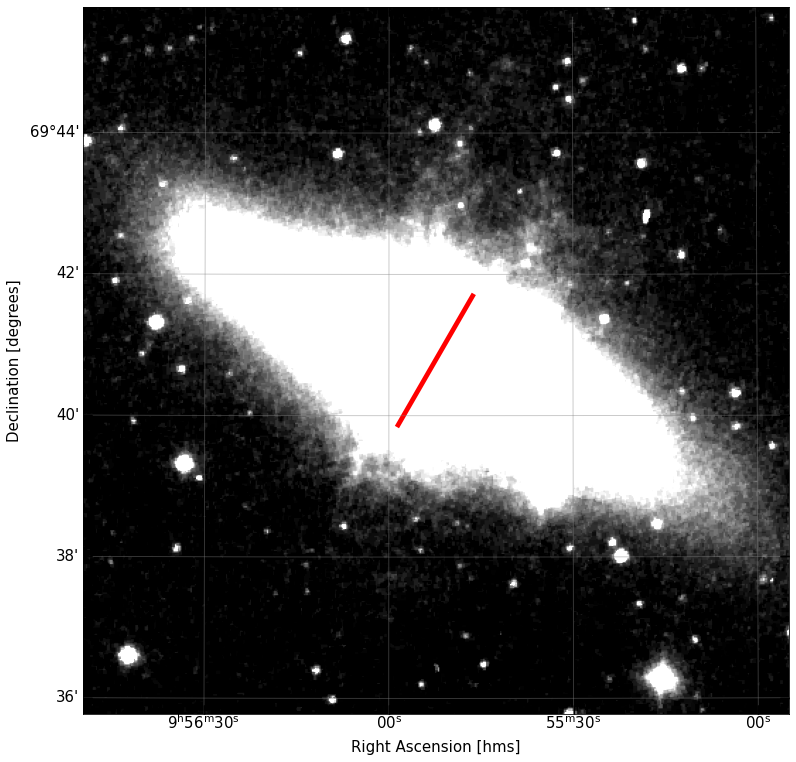

In [19]:
m82.retrieve_finder_chart(config_name='primary',
                         size=10*u.arcmin);

When we have a configuration that has the special keywords `slit_width`, `slit_length` and `PA` defined, we can use this to overplot our slit onto our finder chart. 

The same is true for the fiber / circular aperture, because we set `fiber_radius`:

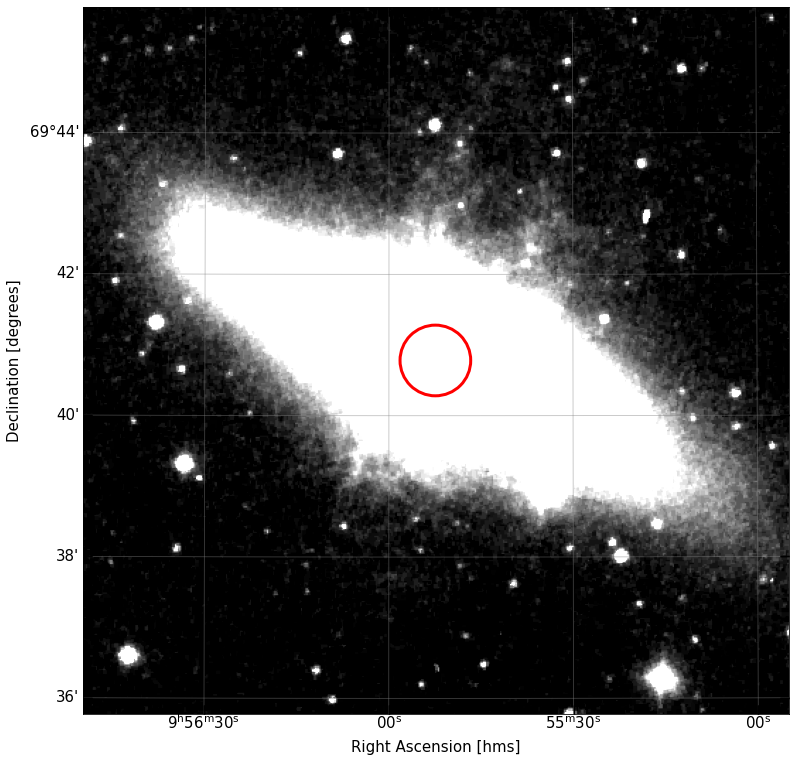

In [20]:
m82.retrieve_finder_chart(config_name='tertiary',
                         size=10*u.arcmin);

### Adding Custom Imaging 

The final convenience function to cover here is that if you have your own image of your target (maybe from your own telescope) and you wish to add it to your configuration, you can do so with the `add_custom_image()` method. (See the API for more). 

### Summary 

So far, we've covered the `Target()` class and how to define targets and set configurations with any number of quantities of interest to us. We also covered a few of the convenient functions we can apply directly onto `Target`s. Most of these come together in our next part: `ObservingPlan()`. 

## Observing Plans

Once we have our targets and their configurations set up as desired, we can ingest these into an observing plan. To do so, we'll need to initialize an `ObservingPlan` object with a list of our `Target`s as well as the dates of our observations and the location they will be at. To make things more interesting, let's define a second target:

In [22]:
m101 = Target('M101')
m101.add_configuration(config_name='on-target',
                    obstype='spectroscopy',
                    PA = -120*u.deg,
                    slit_length=128*u.arcsec,
                    slit_width=2*u.arcsec)

In [23]:
targets = [m82,m101]

In [25]:
plan = ObservingPlan(targets,
                     observatory='Palomar',
                     obsdates='2022-02-25',
                     utcoffset=-8)

Above, we've set up an `ObservingPlan` with our targets. We've specified our observatory as `Palomar`. Any Observatory in the `astropy` database can be used, or, if you have a custom location, you can easily setup an astropy `EarthLocation()` object (which takes a latitude, longitude, and altitude). This can also be directly added. 

I've also set the `obsdates` params. In this case, I provided a single string, but a list of similar strings can be added to put in an observing run. Though if you have different targets for each night, you may wish to separate those out. Finally, we specify the utc offset of the observatory... there's probably a way for me to automate this, but for now just do it. 

### Altitude / Airmass Plot

Immediately upon making our plan, we have access to a useful method. 

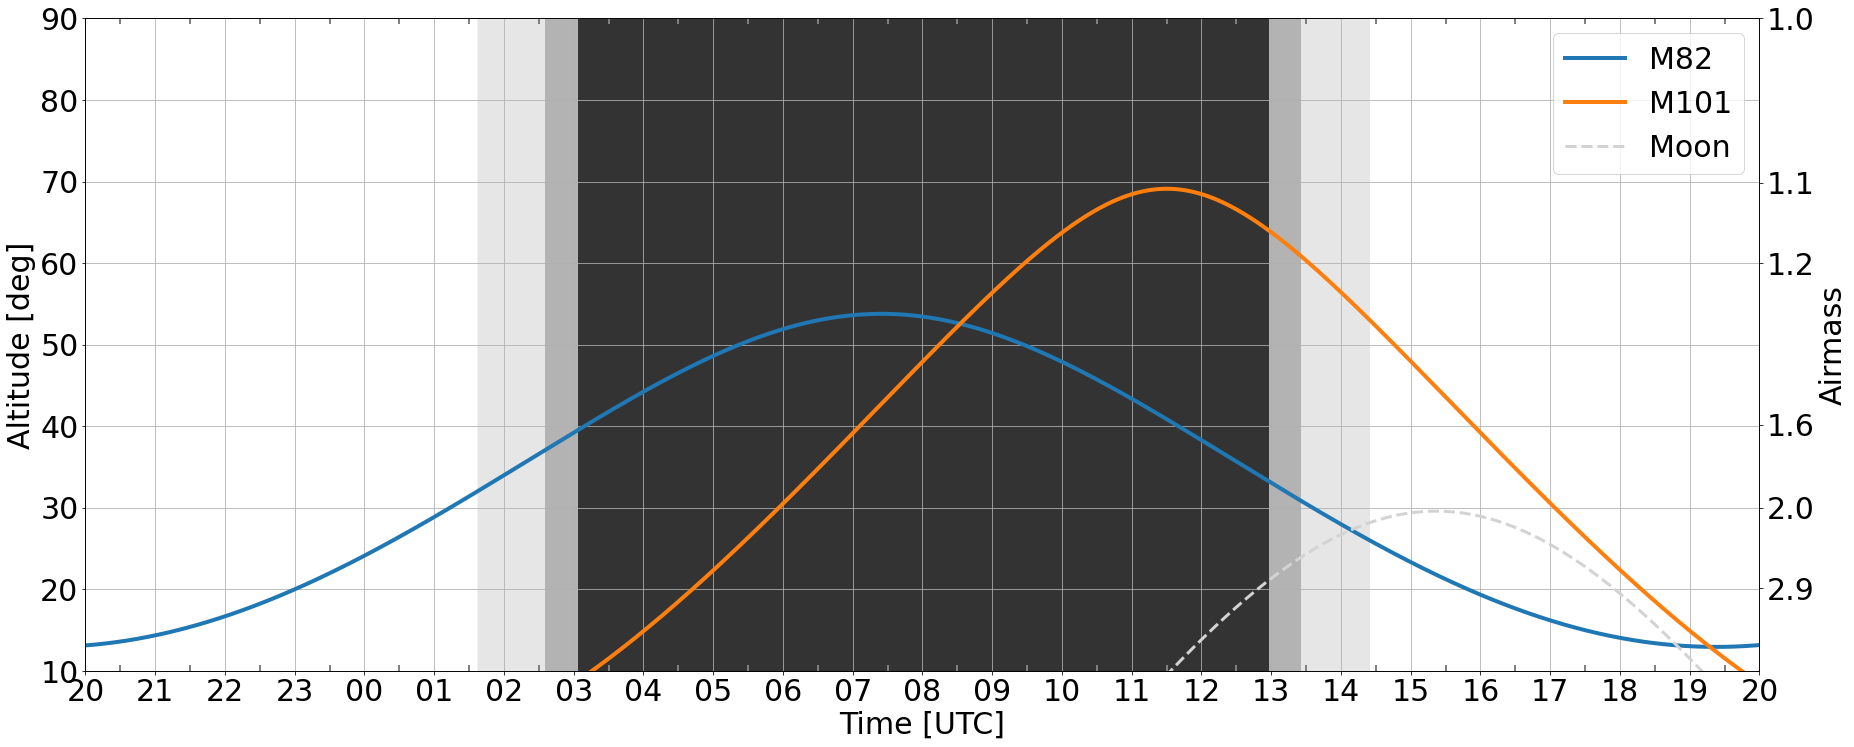

In [28]:
plan.plot_visibility('2022-02-25');

By default, this plot will show each target as well as the moon. It shows your standard nighttime, 18 degree twilight, and 12 degree twilight lines. Here's an example of some of the keywords:

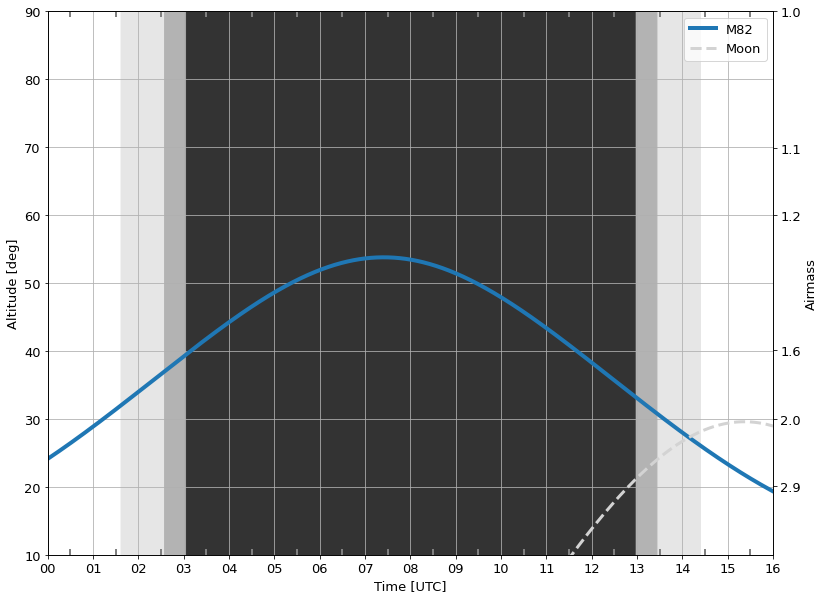

In [30]:
plan.plot_visibility('2022-02-25',target='M82',view_range=8,figsize=(13,10));

So we can set the range (about midnight) that gets shown, we can specify individual targets (or provide a list of targets as strings), and manually set the figure size. 

## Observing Plan HTML Output

The first major thing we can do with our observing plan is, in essence, have it loop over all our targets and put together a unified observing guide which has the full visibility plot, then for each target, shows its visibility plot, its configurations, and its finder images. 

This stage is still under construction, but is (marginally) functional, via

In [ ]:
plan.html_summary('2022-02-25',save_dir='./');

Which will create a folder for that date, and within make the html (and an `img` folder for the plots). 

You can see an example of this in the `Examples/` folder. 